# OULAD Student Performance Prediction

## Problem Definition and Objectives
We aim to predict whether a student will pass or fail a course using early, non?leaking signals. The objective is to build models that support early warning and student support interventions.


## Project Requirements and Rubric Alignment

**Problem Definition & Objectives**
- Predict whether a student will pass or fail using early, non?leaking signals.
- Support early?warning interventions and academic support planning.

**Data Understanding & Preprocessing**
- Dataset description: OULAD tables (studentInfo, studentVle, studentAssessment, assessments, courses, studentRegistration).
- Handling missing values, noise, and outliers is explicitly documented in cleaning/preprocessing.
- Feature engineering covers engagement, activity composition, registration, and assessment?presence indicators.
- All preprocessing steps are justified for stability and early?warning use cases.

**Algorithm Selection & Modeling**
- Baselines: Logistic Regression (interpretable) and Decision Tree (rule?based).
- Complex models: H2O AutoML for broad search; XGBoost for optimized boosting performance.
- Models are trained and evaluated consistently on the same split.

**Evaluation & Results Analysis**
- Metrics: Accuracy, Precision, Recall, F1, AUC, LogLoss.
- Interpretation addresses strengths, limitations, and early?warning suitability.

**Report Quality & Presentation**
- Clear structure, visuals, and conclusions with actionable insights.

**Bonus**
- Multiple algorithms compared.
- Real?world, large?scale dataset (OULAD).
- Practical recommendations for early?warning interventions.


## Input: Setup and Configuration
All imports and environment initialization (including H2O) are defined here.


In [1]:
# --- Setup and configuration
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, log_loss

import h2o
from h2o.automl import H2OAutoML
import optuna
import xgboost as xgb

pd.set_option('display.max_columns', 200)
np.random.seed(42)

# Runtime config
TEST_MODE = False  # set True for quick test
AUTOML_MAX_MODELS = 20
AUTOML_MAX_RUNTIME_SECS = 5400  # 1.5 hours
XGB_TRIALS = 10
XGB_EARLY_STOPPING_ROUNDS = 50

if TEST_MODE:
    AUTOML_MAX_MODELS = 1
    AUTOML_MAX_RUNTIME_SECS = 300
    XGB_TRIALS = 1

os.makedirs('h2o_logs', exist_ok=True)

# Initialize H2O
h2o.init(max_mem_size='6G', log_dir='./h2o_logs', log_level='INFO', nthreads=-1)


Checking whether there is an H2O instance running at http://localhost:54321.

C:\Users\Than Minh\AppData\Roaming\Python\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


.... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.12+8-LTS-286, mixed mode, sharing)
  Starting server from C:\Users\Than Minh\AppData\Roaming\Python\Python311\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\THANMI~1\AppData\Local\Temp\tmp04kqht65
  JVM stdout: C:\Users\THANMI~1\AppData\Local\Temp\tmp04kqht65\h2o_Than_Minh_started_from_python.out
  JVM stderr: C:\Users\THANMI~1\AppData\Local\Temp\tmp04kqht65\h2o_Than_Minh_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Asia/Ho_Chi_Minh
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.9
H2O_cluster_version_age:,2 months and 8 days
H2O_cluster_name:,H2O_from_python_Than_Minh_qe6d8x
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,6 Gb
H2O_cluster_total_cores:,20
H2O_cluster_allowed_cores:,20
H2O_cluster_status:,"locked, healthy"


## Data Loading
We load the OULAD tables and confirm their shape before cleaning.


In [2]:
# CHANGE THIS to your local folder containing the 7 OULAD CSV files
DEFAULT_DATA_DIR = os.path.join('.', 'data')

required_files = [
    'assessments.csv','courses.csv','studentAssessment.csv','studentInfo.csv',
    'studentRegistration.csv','studentVle.csv','vle.csv'
]

# Resolve DATA_DIR from common locations
candidate_dirs = [DEFAULT_DATA_DIR, '.']
resolved = None
for d in candidate_dirs:
    if all(os.path.exists(os.path.join(d, f)) for f in required_files):
        resolved = d
        break

if resolved is None:
    missing = [f for f in required_files if not os.path.exists(os.path.join(DEFAULT_DATA_DIR, f))]
    print('Missing files in DEFAULT_DATA_DIR:', missing)
    print('DEFAULT_DATA_DIR currently set to:', os.path.abspath(DEFAULT_DATA_DIR))
    print('Also checked:', os.path.abspath('.'))
else:
    DATA_DIR = resolved
    print('Using DATA_DIR:', os.path.abspath(DATA_DIR))


Using DATA_DIR: d:\Project\DBM_FINAL\data


In [3]:
def read_csv(name, usecols=None, dtype=None):
    path = os.path.join(DATA_DIR, name)
    return pd.read_csv(path, usecols=usecols, dtype=dtype, low_memory=False)
def preview_df(name, df, n=5):
    print(f"\nPreview: {name}")
    print('shape:', df.shape)
    print(df.head(n))

# Read small/medium tables fully
assessments = read_csv('assessments.csv')
courses = read_csv('courses.csv')
student_info = read_csv('studentInfo.csv')
student_reg = read_csv('studentRegistration.csv')
student_assess = read_csv('studentAssessment.csv')
vle = read_csv('vle.csv')

# Read the large clickstream table with only needed columns + smaller dtypes
student_vle = read_csv(
    'studentVle.csv',
    usecols=['code_module','code_presentation','id_student','id_site','date','sum_click'],
    dtype={
        'code_module':'category','code_presentation':'category',
        'id_student':'int32','id_site':'int32',
        'date':'int16','sum_click':'int32'
    }
)

# Quick overview (rows, cols)
overview = pd.DataFrame({
    'table': ['assessments','courses','studentInfo','studentRegistration','studentAssessment','vle','studentVle'],
    'rows': [len(assessments),len(courses),len(student_info),len(student_reg),len(student_assess),len(vle),len(student_vle)],
    'cols': [assessments.shape[1],courses.shape[1],student_info.shape[1],student_reg.shape[1],student_assess.shape[1],vle.shape[1],student_vle.shape[1]]
})
overview


,table,rows,cols
0,assessments,206,6
1,courses,22,3
2,studentInfo,32593,12
3,studentRegistration,32593,5
4,studentAssessment,173912,5
5,vle,6364,6
6,studentVle,10655280,6


## Data Cleaning
We clean raw tables (types, invalid values, deduplication). **No leakage drop occurs here**; all features are retained.


In [4]:
# --- 3.1 assessments: drop known invalid IDs (common in OULAD copies)
# If IDs are missing in your version, this line is harmless.
invalid_ids = {40087, 40088}
assessments = assessments[~assessments['id_assessment'].isin(invalid_ids)].copy()

# Ensure numeric types where needed
assessments['weight'] = pd.to_numeric(assessments['weight'], errors='coerce')
assessments['date'] = pd.to_numeric(assessments['date'], errors='coerce')

# --- 3.2 studentAssessment: clean score/date
student_assess['score'] = student_assess['score'].replace(['?', '', ' '], np.nan)
student_assess['score'] = pd.to_numeric(student_assess['score'], errors='coerce')
student_assess['date_submitted'] = pd.to_numeric(student_assess['date_submitted'], errors='coerce')
student_assess['is_banked'] = pd.to_numeric(student_assess['is_banked'], errors='coerce').fillna(0).astype(int)

before = len(student_assess)
student_assess = student_assess.dropna(subset=['score']).copy()
print('Dropped rows with missing/non-numeric score:', before - len(student_assess))

# --- 3.3 studentInfo: clean imd_band and normalize age label
student_info['imd_band'] = student_info['imd_band'].replace('?', np.nan)
student_info['age_band'] = student_info['age_band'].replace({'55<=': '>=55'})

# --- 3.4 studentVle: drop duplicates to avoid inflated click counts
before = len(student_vle)
student_vle = student_vle.drop_duplicates().copy()
print('Dropped duplicate rows in studentVle:', before - len(student_vle))

# Sanity
print('studentVle rows after dedup:', len(student_vle))


Dropped rows with missing/non-numeric score: 173
Dropped duplicate rows in studentVle: 787170
studentVle rows after dedup: 9868110


## Feature Engineering (Full Feature Space)
We construct the target and build engagement, assessment, and registration aggregates. All features are retained for EDA.


In [5]:
# --- 4.1 Create target (binary) from final_result
student_info['final_result_upd'] = student_info['final_result'].replace({
    'Distinction': 'Pass',
    'Withdrawn': 'Fail'
})
student_info = student_info[student_info['final_result_upd'].isin(['Pass','Fail'])].copy()
student_info['final_result_upd_numeric'] = (student_info['final_result_upd'] == 'Pass').astype(int)

# --- 4.2 VLE features (aggregate to student-module-presentation grain)
# total clicks + active days
vle_agg = (
    student_vle
    .groupby(['id_student','code_module','code_presentation'], as_index=False, observed=True)
    .agg(
        total_sum_click=('sum_click','sum'),
        active_days=('date','nunique'),
        distinct_sites=('id_site','nunique')
    )
)

# early engagement (<= 14 days)
early = student_vle[student_vle['date'] <= 14]
early_agg = (
    early.groupby(['id_student','code_module','code_presentation'], as_index=False, observed=True)
         .agg(early_sum_click=('sum_click','sum'), early_active_days=('date','nunique'))
)

vle_features = vle_agg.merge(early_agg, on=['id_student','code_module','code_presentation'], how='left')
vle_features[['early_sum_click','early_active_days']] = vle_features[['early_sum_click','early_active_days']].fillna(0)

vle_features['early_click_ratio'] = vle_features['early_sum_click'] / vle_features['total_sum_click'].replace(0, np.nan)
vle_features['early_click_ratio'] = vle_features['early_click_ratio'].fillna(0)

# per-day intensity
vle_features['clicks_per_active_day'] = vle_features['total_sum_click'] / vle_features['active_days'].replace(0, np.nan)
vle_features['clicks_per_active_day'] = vle_features['clicks_per_active_day'].fillna(0)

vle_features['early_clicks_per_active_day'] = vle_features['early_sum_click'] / vle_features['early_active_days'].replace(0, np.nan)
vle_features['early_clicks_per_active_day'] = vle_features['early_clicks_per_active_day'].fillna(0)

vle_features['early_active_ratio'] = vle_features['early_active_days'] / vle_features['active_days'].replace(0, np.nan)
vle_features['early_active_ratio'] = vle_features['early_active_ratio'].fillna(0)

# activity type aggregates
vle_types = student_vle.merge(vle[['id_site','activity_type']], on='id_site', how='left')

vle_type_agg = (
    vle_types.groupby(['id_student','code_module','code_presentation','activity_type'], observed=True)
             .agg(type_clicks=('sum_click','sum'))
             .reset_index()
)

vle_type_pivot = vle_type_agg.pivot_table(
    index=['id_student','code_module','code_presentation'],
    columns='activity_type',
    values='type_clicks',
    fill_value=0
).reset_index()

# Rename columns for clarity
for col in vle_type_pivot.columns:
    if col not in ['id_student','code_module','code_presentation']:
        vle_type_pivot = vle_type_pivot.rename(columns={col: f'clicks_type_{col}'})

# Merge activity type features into main VLE feature set
vle_features = vle_features.merge(vle_type_pivot, on=['id_student','code_module','code_presentation'], how='left')

# Count of activity types used
type_cols = [c for c in vle_features.columns if c.startswith('clicks_type_')]
vle_features['distinct_activity_types'] = (vle_features[type_cols] > 0).sum(axis=1)
# activity type distribution features
type_cols = [c for c in vle_features.columns if c.startswith('clicks_type_')]
type_sum = vle_features[type_cols].sum(axis=1).replace(0, np.nan)
type_probs = vle_features[type_cols].div(type_sum, axis=0).fillna(0)
vle_features['activity_entropy'] = -(type_probs * np.log(type_probs + 1e-9)).sum(axis=1)
vle_features['top_type_share'] = type_probs.max(axis=1)

# log transforms to reduce skew
vle_features['log1p_total_sum_click'] = np.log1p(vle_features['total_sum_click'])
vle_features['log1p_early_sum_click'] = np.log1p(vle_features['early_sum_click'])

# Transparency: check target transformation
preview_df('student_info (target)', student_info)

# Transparency: VLE aggregates
preview_df('vle_agg', vle_agg)
preview_df('early_agg', early_agg)
preview_df('vle_features', vle_features)


C:\Users\Than Minh\AppData\Local\Temp\ipykernel_37992\2128201024.py:53: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  vle_type_pivot = vle_type_agg.pivot_table(



Preview: student_info (target)
shape: (32593, 14)
  code_module code_presentation  id_student gender                region  \
0         AAA             2013J       11391      M   East Anglian Region   
1         AAA             2013J       28400      F              Scotland   
2         AAA             2013J       30268      F  North Western Region   
3         AAA             2013J       31604      F     South East Region   
4         AAA             2013J       32885      F  West Midlands Region   

       highest_education imd_band age_band  num_of_prev_attempts  \
0       HE Qualification  90-100%     >=55                     0   
1       HE Qualification   20-30%    35-55                     0   
2  A Level or Equivalent   30-40%    35-55                     0   
3  A Level or Equivalent   50-60%    35-55                     0   
4     Lower Than A Level   50-60%     0-35                     0   

   studied_credits disability final_result final_result_upd  \
0              240  

In [6]:
# --- 4.3 Assessment features: weighted score and overall grade
# Join studentAssessment with assessments metadata
sa = student_assess.merge(
    assessments[['id_assessment','code_module','code_presentation','assessment_type','weight','date']],
    on='id_assessment', how='left'
)

# Weighted score rule: if is_banked==1 -> 0 else score * weight
sa['weighted_score'] = np.where(sa['is_banked'] == 1, 0, sa['score'] * (sa['weight'] / 100.0))

# Lateness (optional feature)
sa['lateness_days'] = sa['date_submitted'] - sa['date']

assess_agg = (
    sa.groupby(['id_student','code_module','code_presentation'], as_index=False, observed=True)
      .agg(
          exam_weighted=('weighted_score', lambda x: x[sa.loc[x.index,'assessment_type'].eq('Exam')].sum()),
          non_exam_weighted=('weighted_score', lambda x: x[~sa.loc[x.index,'assessment_type'].eq('Exam')].sum()),
          mean_score=('score','mean'),
          late_submissions=('lateness_days', lambda s: (s>0).sum())
      )
)

# overall_grade rule: average if both exist, else use the one available
assess_agg['has_exam'] = (assess_agg['exam_weighted'] > 0).astype(int)
assess_agg['has_non_exam'] = (assess_agg['non_exam_weighted'] > 0).astype(int)
assess_agg['overall_grade'] = np.where(
    (assess_agg['has_exam']==1) & (assess_agg['has_non_exam']==1),
    (assess_agg['exam_weighted'] + assess_agg['non_exam_weighted']) / 2.0,
    np.where(assess_agg['has_exam']==1, assess_agg['exam_weighted'], assess_agg['non_exam_weighted'])
)

# Transparency: assessment aggregates
preview_df('assess_agg', assess_agg)



Preview: assess_agg
shape: (25820, 10)
   id_student code_module code_presentation  exam_weighted  non_exam_weighted  \
0        6516         AAA             2014J            0.0              63.50   
1        8462         DDD             2013J            0.0              34.90   
2        8462         DDD             2014J            0.0               0.00   
3       11391         AAA             2013J            0.0              82.40   
4       23629         BBB             2013B            0.0              16.69   

   mean_score  late_submissions  has_exam  has_non_exam  overall_grade  
0   61.800000                 0         0             1          63.50  
1   87.666667                 1         0             1          34.90  
2   86.500000                 0         0             0           0.00  
3   82.000000                 0         0             1          82.40  
4   82.500000                 3         0             1          16.69  


In [7]:
# --- 4.4 Registration features
student_reg['date_registration'] = pd.to_numeric(student_reg['date_registration'], errors='coerce')
student_reg['date_unregistration'] = pd.to_numeric(student_reg['date_unregistration'], errors='coerce')

reg_features = student_reg[['id_student','code_module','code_presentation','date_registration','date_unregistration']].copy()
reg_features['unregistered_flag'] = reg_features['date_unregistration'].notna().astype(int)

# Transparency: registration features
preview_df('reg_features', reg_features)



Preview: reg_features
shape: (32593, 6)
   id_student code_module code_presentation  date_registration  \
0       11391         AAA             2013J             -159.0   
1       28400         AAA             2013J              -53.0   
2       30268         AAA             2013J              -92.0   
3       31604         AAA             2013J              -52.0   
4       32885         AAA             2013J             -176.0   

   date_unregistration  unregistered_flag  
0                  NaN                  0  
1                  NaN                  0  
2                 12.0                  1  
3                  NaN                  0  
4                  NaN                  0  


In [8]:
# --- Build final dataset at student-module-presentation grain
final_data = (
    student_info
      .merge(vle_features, on=['id_student','code_module','code_presentation'], how='left')
      .merge(assess_agg, on=['id_student','code_module','code_presentation'], how='left')
      .merge(reg_features, on=['id_student','code_module','code_presentation'], how='left')
      .merge(courses, on=['code_module','code_presentation'], how='left')
)

# Derived registration and engagement ratios
if 'date_registration' in final_data.columns:
    final_data['registered_early_flag'] = (final_data['date_registration'] < 0).astype(int)
    final_data['registration_lead_days'] = (-final_data['date_registration']).clip(lower=0)

if 'date_unregistration' in final_data.columns:
    final_data['unregistered_flag'] = final_data['date_unregistration'].notna().astype(int)

if 'module_presentation_length' in final_data.columns:
    final_data['active_days_ratio'] = final_data['active_days'] / final_data['module_presentation_length'].replace(0, np.nan)
    final_data['active_days_ratio'] = final_data['active_days_ratio'].fillna(0)

print('Final dataset shape:', final_data.shape)

# Transparency: final dataset preview
preview_df('final_data', final_data)


Final dataset shape: (32593, 62)

Preview: final_data
shape: (32593, 62)
  code_module code_presentation  id_student gender                region  \
0         AAA             2013J       11391      M   East Anglian Region   
1         AAA             2013J       28400      F              Scotland   
2         AAA             2013J       30268      F  North Western Region   
3         AAA             2013J       31604      F     South East Region   
4         AAA             2013J       32885      F  West Midlands Region   

       highest_education imd_band age_band  num_of_prev_attempts  \
0       HE Qualification  90-100%     >=55                     0   
1       HE Qualification   20-30%    35-55                     0   
2  A Level or Equivalent   30-40%    35-55                     0   
3  A Level or Equivalent   50-60%    35-55                     0   
4     Lower Than A Level   50-60%     0-35                     0   

   studied_credits disability final_result final_result_upd  

## Exploratory Data Analysis (EDA)

We separate EDA into (1) data visualizations to understand distributions and patterns, and (2) leakage investigation to identify outcome?dependent signals.


### EDA Part A: Data Visualization


                 table     rows  cols
0          assessments      204     6
1              courses       22     3
2          studentInfo    32593    14
3  studentRegistration    32593     5
4    studentAssessment   173739     5
5                  vle     6364     6
6           studentVle  9868110     6


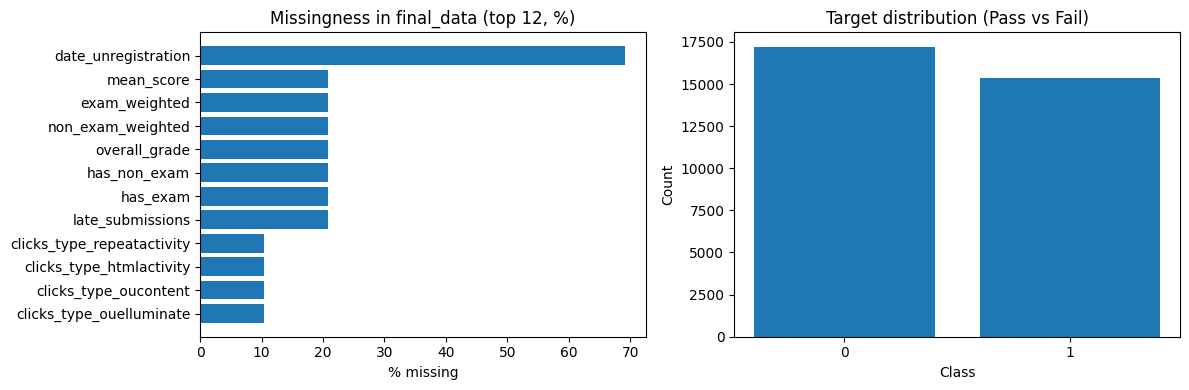

Target counts:
final_result_upd_numeric
0    17208
1    15385
Name: count, dtype: int64
Target %:
final_result_upd_numeric
0    52.8
1    47.2
Name: count, dtype: float64
Imbalance ratio (majority/minority): 1.12x


In [9]:
# --- EDA: overview, missingness, target balance
overview = pd.DataFrame({
    'table': ['assessments','courses','studentInfo','studentRegistration','studentAssessment','vle','studentVle'],
    'rows': [len(assessments),len(courses),len(student_info),len(student_reg),len(student_assess),len(vle),len(student_vle)],
    'cols': [assessments.shape[1],courses.shape[1],student_info.shape[1],student_reg.shape[1],student_assess.shape[1],vle.shape[1],student_vle.shape[1]]
})
print(overview)

miss = (final_data.isna().mean() * 100).sort_values(ascending=False).head(12)
counts = final_data['final_result_upd_numeric'].value_counts()
perc = counts / counts.sum() * 100
imbalance = counts.max() / counts.min()

fig, axes = plt.subplots(1, 2, figsize=(12,4))
axes[0].barh(miss.index.astype(str), miss.values)
axes[0].set_title('Missingness in final_data (top 12, %)')
axes[0].invert_yaxis()
axes[0].set_xlabel('% missing')

axes[1].bar(counts.index.astype(str), counts.values)
axes[1].set_title('Target distribution (Pass vs Fail)')
axes[1].set_ylabel('Count')
axes[1].set_xlabel('Class')

plt.tight_layout()
plt.show()

print('Target counts:')
print(counts)
print('Target %:')
print(perc.round(2))
print(f'Imbalance ratio (majority/minority): {imbalance:.2f}x')


C:\Users\Than Minh\AppData\Local\Temp\ipykernel_37992\89971386.py:23: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax2.boxplot([fail_vals.dropna(), pass_vals.dropna()], labels=['Fail','Pass'])
C:\Users\Than Minh\AppData\Local\Temp\ipykernel_37992\89971386.py:23: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax2.boxplot([fail_vals.dropna(), pass_vals.dropna()], labels=['Fail','Pass'])
C:\Users\Than Minh\AppData\Local\Temp\ipykernel_37992\89971386.py:23: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax2.boxplot([fail_vals.dropna(), pass_vals.dropna()], labels=['Fail','Pass'])


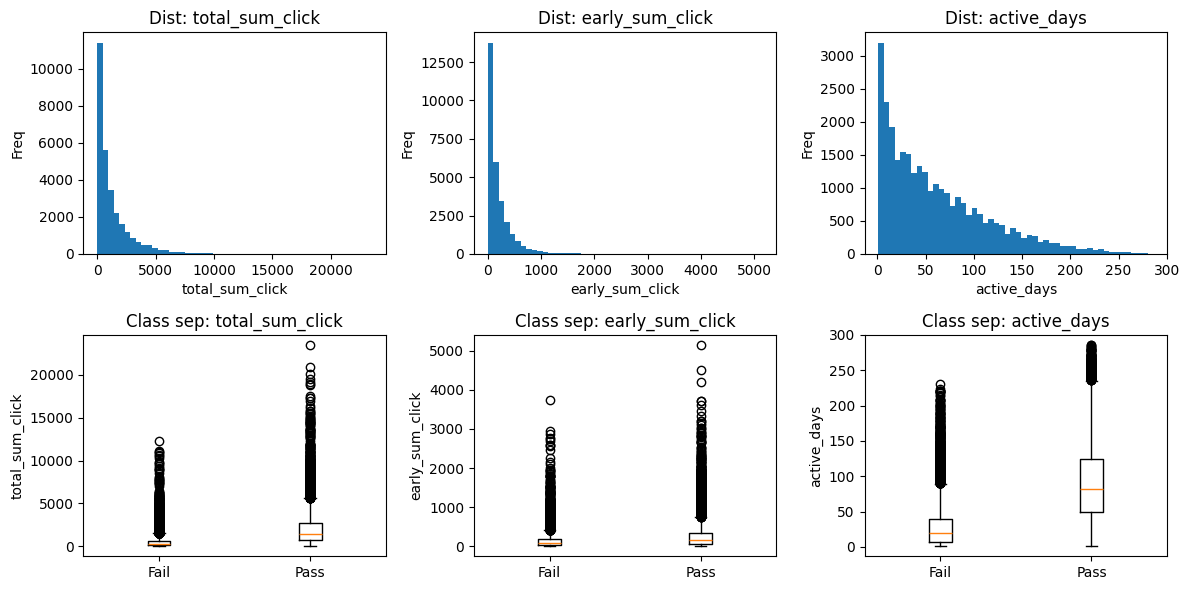

In [10]:
# --- EDA: distributions + class separation (selected numeric features)
key_num = [
    'total_sum_click','early_sum_click','active_days','clicks_per_active_day',
    'distinct_activity_types','activity_entropy','top_type_share',
    'module_presentation_length','registration_lead_days','date_registration'
]
cols = [c for c in key_num if c in final_data.columns]

ncols = 3
nrows = 2
fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 6))

for i, col in enumerate(cols[:ncols]):
    ax = axes[0, i]
    ax.hist(final_data[col].dropna(), bins=50)
    ax.set_title(f'Dist: {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Freq')

    ax2 = axes[1, i]
    pass_vals = final_data.loc[final_data['final_result_upd_numeric']==1, col]
    fail_vals = final_data.loc[final_data['final_result_upd_numeric']==0, col]
    ax2.boxplot([fail_vals.dropna(), pass_vals.dropna()], labels=['Fail','Pass'])
    ax2.set_title(f'Class sep: {col}')
    ax2.set_ylabel(col)

plt.tight_layout()
plt.show()


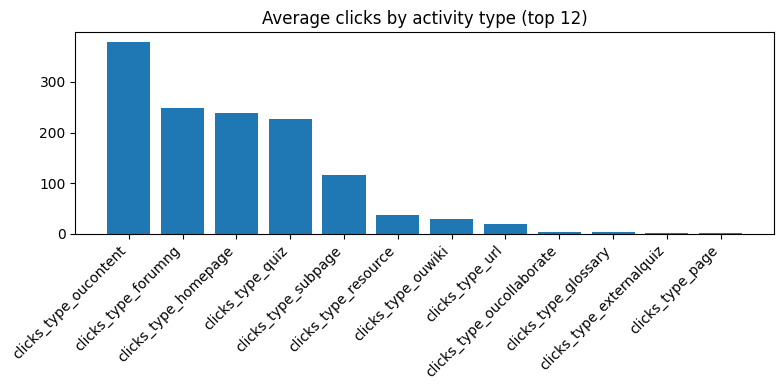

In [11]:
# --- EDA: activity-type click distributions
click_cols = [c for c in final_data.columns if c.startswith('clicks_type_')]
if click_cols:
    avg_clicks = final_data[click_cols].mean().sort_values(ascending=False).head(12)
    plt.figure(figsize=(8,4))
    plt.bar(avg_clicks.index.astype(str), avg_clicks.values)
    plt.title('Average clicks by activity type (top 12)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


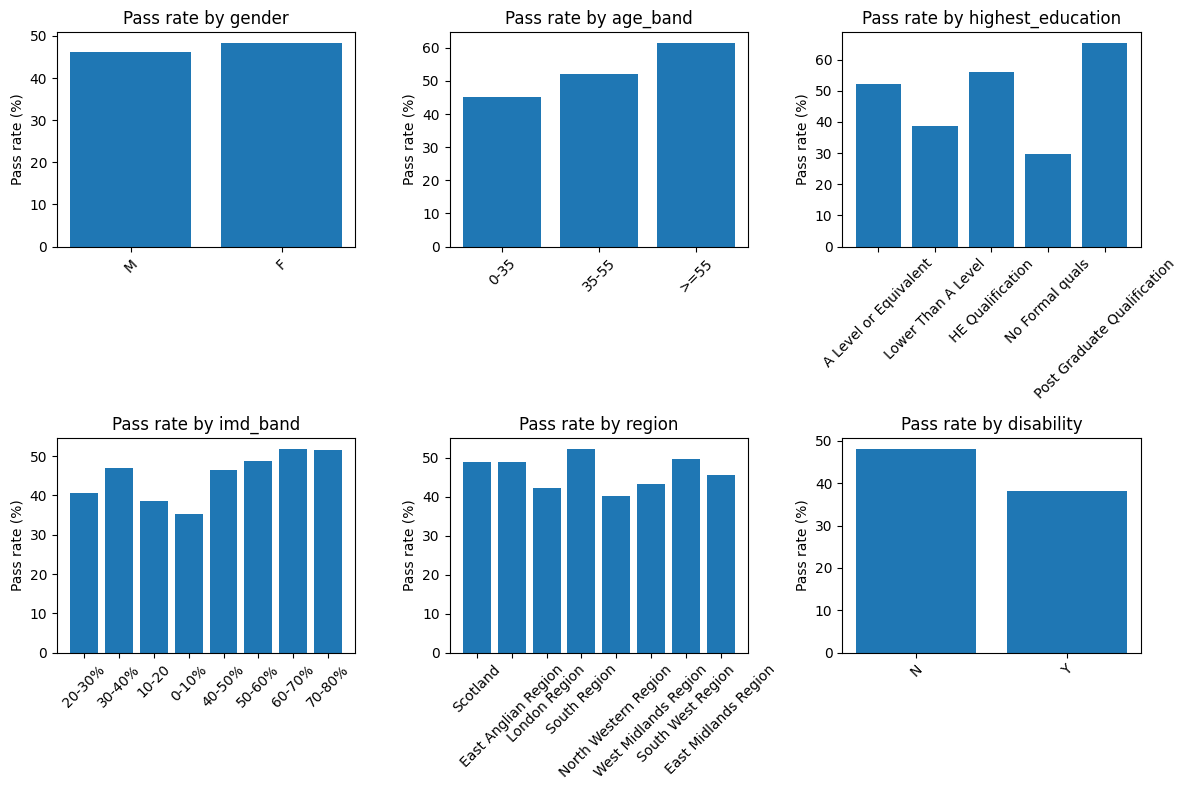

In [12]:
# --- EDA: pass rates by demographics
cat_cols = ['gender','age_band','highest_education','imd_band','region','disability']
fig, axes = plt.subplots(2, 3, figsize=(12,8))
axes = axes.flatten()

for ax, col in zip(axes, cat_cols):
    if col not in final_data.columns:
        ax.axis('off')
        continue
    grp = (
        final_data.groupby(col)['final_result_upd_numeric']
        .agg(['mean','count'])
        .sort_values('count', ascending=False)
        .head(8)
    )
    ax.bar(grp.index.astype(str), grp['mean'] * 100)
    ax.set_title(f'Pass rate by {col}')
    ax.set_ylabel('Pass rate (%)')
    ax.tick_params(axis='x', rotation=45)

# Turn off any unused axes
for ax in axes[len(cat_cols):]:
    ax.axis('off')

plt.tight_layout()
plt.show()


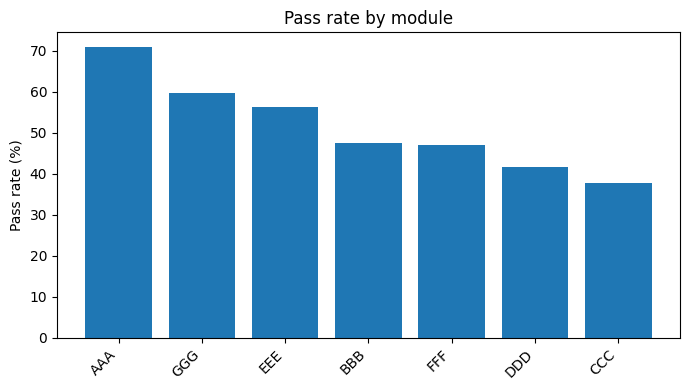

In [13]:
# --- EDA: pass rates by module
if 'code_module' in final_data.columns:
    module_rates = (
        final_data.groupby('code_module')['final_result_upd_numeric']
        .agg(['mean','count'])
        .sort_values('mean', ascending=False)
    )

    plt.figure(figsize=(7,4))
    plt.bar(module_rates.index.astype(str), module_rates['mean'] * 100)
    plt.title('Pass rate by module')
    plt.ylabel('Pass rate (%)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


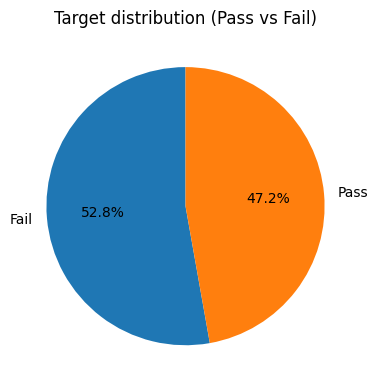

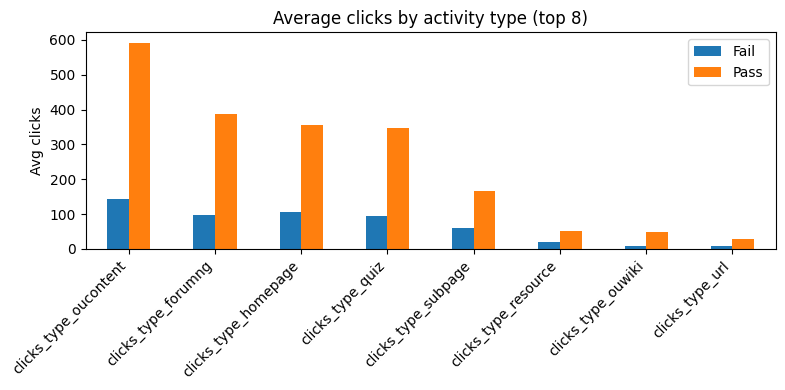

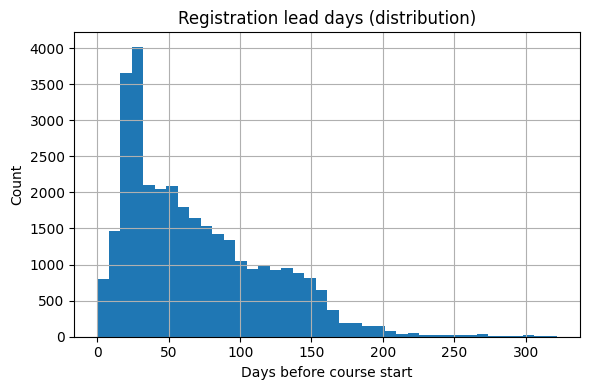

In [14]:
# --- EDA: target distribution (pie)
labels = ['Fail','Pass']
vals = final_data['final_result_upd_numeric'].value_counts().reindex([0,1]).fillna(0).values
plt.figure(figsize=(4,4))
plt.pie(vals, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('Target distribution (Pass vs Fail)')
plt.tight_layout()
plt.show()

# --- EDA: top activity types (stacked bar by outcome)
click_cols = [c for c in final_data.columns if c.startswith('clicks_type_')]
if click_cols:
    top = final_data[click_cols].mean().sort_values(ascending=False).head(8).index.tolist()
    grp = final_data.groupby('final_result_upd_numeric')[top].mean().T
    grp.columns = ['Fail','Pass']
    grp.plot(kind='bar', figsize=(8,4))
    plt.title('Average clicks by activity type (top 8)')
    plt.ylabel('Avg clicks')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# --- EDA: registration timing distribution
if 'registration_lead_days' in final_data.columns:
    plt.figure(figsize=(6,4))
    final_data['registration_lead_days'].hist(bins=40)
    plt.title('Registration lead days (distribution)')
    plt.xlabel('Days before course start')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()


### EDA Part B: Leakage Investigation


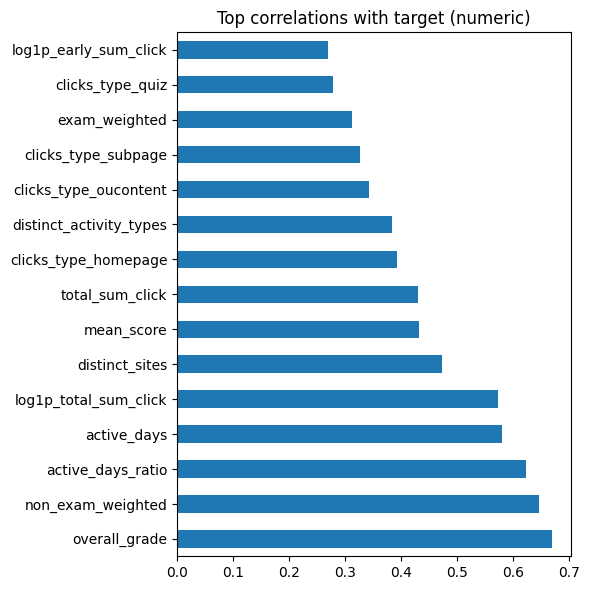

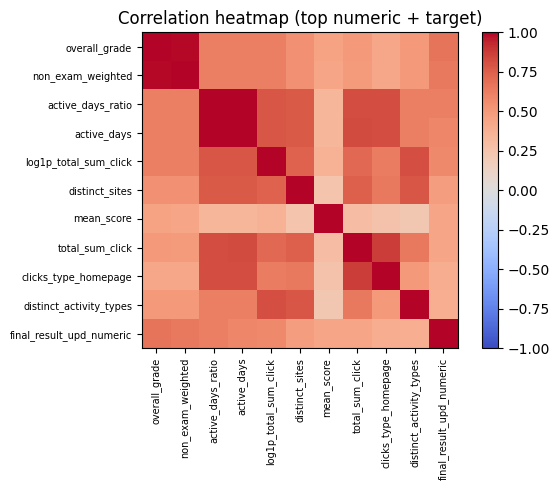

In [15]:
# --- EDA: correlation visualization (numeric features)
num_cols = final_data.select_dtypes(include=['number']).columns.tolist()

corrs = (
    final_data[num_cols]
    .corr(numeric_only=True)['final_result_upd_numeric']
    .sort_values(ascending=False)
)

plt.figure(figsize=(6,6))
corrs.drop('final_result_upd_numeric').head(15).plot(kind='barh')
plt.title('Top correlations with target (numeric)')
plt.tight_layout()
plt.show()

# Small heatmap of top correlated numeric features
top_cols = corrs.drop('final_result_upd_numeric').head(10).index.tolist()
heat_cols = top_cols + ['final_result_upd_numeric']
heat = final_data[heat_cols].corr(numeric_only=True)

plt.figure(figsize=(7,5))
im = plt.imshow(heat, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.xticks(range(len(heat.columns)), heat.columns, rotation=90, fontsize=7)
plt.yticks(range(len(heat.index)), heat.index, fontsize=7)
plt.title('Correlation heatmap (top numeric + target)')
plt.tight_layout()
plt.show()


In [16]:
# --- EDA: leakage detection cues
suspicious = [c for c in final_data.columns if any(k in c.lower() for k in ['final', 'result', 'grade', 'score', 'late', 'unregister'])]
print('Suspicious columns (name-based):')
print(suspicious)

# Single-feature AUC scan (rough signal)
auc_rank = []
y = final_data['final_result_upd_numeric'].astype(int)

for col in final_data.columns:
    if col == 'final_result_upd_numeric':
        continue
    s = final_data[col]
    if s.isna().all() or s.nunique(dropna=True) <= 1:
        continue
    if s.dtype.kind in 'ifc':
        x = s
    else:
        x = pd.Series(pd.factorize(s)[0], index=s.index)
    try:
        auc = roc_auc_score(y, x)
    except Exception:
        continue
    auc_rank.append((col, auc))

auc_rank = sorted(auc_rank, key=lambda x: x[1], reverse=True)
print()
print('Top 15 single-feature AUCs (potential leakage signals):')
for row in auc_rank[:15]:
    print(row)


Suspicious columns (name-based):
['final_result', 'final_result_upd', 'final_result_upd_numeric', 'mean_score', 'late_submissions', 'overall_grade', 'unregistered_flag']

Top 15 single-feature AUCs (potential leakage signals):
('active_days_ratio', 0.8976998930442825)
('module_presentation_length', 0.5264924432212301)
('code_module', 0.5189751458270726)
('id_student', 0.5161553842662534)
('gender', 0.5111788045315138)
('registered_early_flag', 0.5007165987749423)
('region', 0.49383658423416216)
('disability', 0.4823634324007079)
('age_band', 0.4689617782509877)
('code_presentation', 0.4676290603776282)
('num_of_prev_attempts', 0.4633296773635982)
('imd_band', 0.4504191239361275)
('studied_credits', 0.42856761870702187)
('highest_education', 0.4281445626864907)
('unregistered_flag', 0.2073454207345421)


## Feature Drop + Preprocess
Based on EDA and leakage checks, we keep the agreed 40 features and remove all others. We apply additional preprocessing (missing value imputation, scaling, and outlier capping for numeric features) to stabilize training.


In [29]:
# --- Apply final 40-feature list (no external CSV)
TARGET = 'final_result_upd_numeric'
FINAL_FEATURES = [
    'highest_education','imd_band','age_band','num_of_prev_attempts','studied_credits','disability',
    'clicks_per_active_day','clicks_type_dataplus','clicks_type_dualpane','clicks_type_externalquiz',
    'clicks_type_folder','clicks_type_forumng','clicks_type_glossary','clicks_type_homepage',
    'clicks_type_htmlactivity','clicks_type_oucollaborate','clicks_type_oucontent',
    'clicks_type_ouelluminate','clicks_type_ouwiki','clicks_type_page','clicks_type_questionnaire',
    'clicks_type_quiz','clicks_type_repeatactivity','clicks_type_resource','clicks_type_sharedsubpage',
    'clicks_type_subpage','clicks_type_url','distinct_activity_types','activity_entropy','top_type_share',
    'registered_early_flag','registration_lead_days',

    # Added safe engagement signals
    'total_sum_click','active_days','distinct_sites','early_sum_click','early_active_days',
    'early_click_ratio','early_clicks_per_active_day','early_active_ratio',
    'log1p_total_sum_click','log1p_early_sum_click',

    # Added context/structure signals
    'module_presentation_length','date_registration','has_exam','has_non_exam'
]

missing = [f for f in FINAL_FEATURES if f not in final_data.columns]
if missing:
    print('Missing features (not found in dataset):', missing)

FINAL_FEATURES = [f for f in FINAL_FEATURES if f in final_data.columns]

model_data = final_data[FINAL_FEATURES + [TARGET]].copy()

# Outlier capping on numeric features (1st/99th percentile)
num_cols = model_data[FINAL_FEATURES].select_dtypes(include=['number']).columns.tolist()
for c in num_cols:
    low, high = model_data[c].quantile([0.01, 0.99])
    model_data[c] = model_data[c].clip(lower=low, upper=high)

X = model_data[FINAL_FEATURES]
y = model_data[TARGET].astype(int)

# Column types for preprocessing
num_cols = X.select_dtypes(include=['number']).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]

# Preprocessing pipeline
try:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=True)
except TypeError:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse=True)

preprocess = ColumnTransformer([
    ('num', Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]), num_cols),
    ('cat', Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', ohe)
    ]), cat_cols)
])


## Algorithm Principles (Brief)

**Logistic Regression**
- Models the log?odds of the target as a linear function of features.
- Interpretable coefficients; good baseline for binary classification.

**Decision Tree**
- Learns hierarchical if?then splits to separate classes.
- Captures nonlinear relationships; easy to interpret but can overfit.

**XGBoost (Gradient Boosting)**
- Sequentially adds trees to correct previous errors.
- Regularization and shrinkage improve generalization; strong performance on tabular data.

**H2O AutoML**
- Automates model training and hyperparameter search across multiple algorithms.
- Provides a strong leaderboard baseline with minimal manual tuning.


## Modeling
We train models in two stages: (1) simple baselines and (2) AutoML + XGBoost.


In [30]:
# Train/test split (shared across all models)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


### Logistic Regression (Baseline)

Logistic regression models the probability of the positive class using a linear score passed through a sigmoid:

\[ p(y=1\mid x) = \sigma(z) = 
rac{1}{1+e^{-z}}, \quad z = eta_0 + eta^	op x \]

The log?odds (logit) are linear in features:

\[ \log\left(
rac{p}{1-p}
ight) = eta_0 + eta^	op x \]

Training typically minimizes the negative log?likelihood (log loss / cross?entropy):

\[ L_{\log}(y,p) = -(y \log p + (1-y)\log(1-p)) \]

Why it fits this task:
- Interpretable coefficients (direction + magnitude of impact).
- Strong baseline for binary outcomes.
- Works well with mixed numeric + one?hot encoded categorical features.


In [31]:
# --- Logistic Regression
logreg = LogisticRegression(max_iter=2000, class_weight='balanced', random_state=42)
logreg_pipe = Pipeline(steps=[('preprocess', preprocess), ('clf', logreg)])
logreg_pipe.fit(X_train, y_train)

logreg_pred = logreg_pipe.predict(X_test)
logreg_prob = logreg_pipe.predict_proba(X_test)[:, 1]

logreg_metrics = {
    'Model': 'Logistic Regression',
    'Accuracy': accuracy_score(y_test, logreg_pred),
    'Precision': precision_score(y_test, logreg_pred),
    'Recall': recall_score(y_test, logreg_pred),
    'F1': f1_score(y_test, logreg_pred),
    'AUC': roc_auc_score(y_test, logreg_prob),
    'LogLoss': log_loss(y_test, logreg_prob)
}

logreg_metrics


{'Model': 'Logistic Regression',
 'Accuracy': 0.8708390857493481,
 'Precision': 0.8674778033541598,
 'Recall': 0.8573285667858304,
 'F1': 0.8623733246158876,
 'AUC': 0.9372092469913702,
 'LogLoss': 0.3261587929762459}

### Decision Tree (Baseline)

Decision trees split data using impurity criteria (Gini or entropy). For a node with class proportions \(p_k\):

**Gini:**  \( H(Q) = \sum_k p_k(1-p_k) \)

**Entropy:**  \( H(Q) = -\sum_k p_k \log(p_k) \)

The algorithm chooses splits that most reduce impurity, producing human?readable rules.

Why it fits this task:
- Captures non?linear relationships.
- Easy to interpret and explain to stakeholders.
- Useful as a transparent baseline.


In [32]:
# --- Decision Tree
clf_tree = DecisionTreeClassifier(max_depth=6, random_state=42)

tree_pipe = Pipeline(steps=[('preprocess', preprocess), ('clf', clf_tree)])
tree_pipe.fit(X_train, y_train)

tree_pred = tree_pipe.predict(X_test)

tree_prob = None
if hasattr(tree_pipe, 'predict_proba'):
    tree_prob = tree_pipe.predict_proba(X_test)[:, 1]


tree_metrics = {
    'Model': 'Decision Tree',
    'Accuracy': accuracy_score(y_test, tree_pred),
    'Precision': precision_score(y_test, tree_pred),
    'Recall': recall_score(y_test, tree_pred),
    'F1': f1_score(y_test, tree_pred),
    'AUC': roc_auc_score(y_test, tree_prob) if tree_prob is not None else None,
    'LogLoss': log_loss(y_test, tree_prob) if tree_prob is not None else None
}

tree_metrics


{'Model': 'Decision Tree',
 'Accuracy': 0.8732934499156312,
 'Precision': 0.8403386755367402,
 'Recall': 0.9031524211894703,
 'F1': 0.8706140350877193,
 'AUC': 0.9320180635809497,
 'LogLoss': 0.3254451381733806}

### H2O AutoML (Complex Model)

H2O AutoML trains multiple model families (GLM, GBM, DRF, DeepLearning, XRT) and stacked ensembles within a time or model limit. It ranks models on a leaderboard using a chosen metric (AUC here).

Why it fits this task:
- Efficiently explores strong model families without manual tuning.
- Produces an optimized leaderboard and ensemble leader.
- Good for tabular datasets with mixed feature types.


In [33]:
# --- Stage 2A: H2O AutoML
train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

h2o_train = h2o.H2OFrame(train_df)
h2o_test = h2o.H2OFrame(test_df)

h2o_train[TARGET] = h2o_train[TARGET].asfactor()
h2o_test[TARGET] = h2o_test[TARGET].asfactor()

aml = H2OAutoML(
    max_models=AUTOML_MAX_MODELS,
    max_runtime_secs=AUTOML_MAX_RUNTIME_SECS,
    seed=42,
    sort_metric='AUC',
    nfolds=5,
    exclude_algos=['XGBoost'],
    verbosity='info'
)

aml.train(x=FINAL_FEATURES, y=TARGET, training_frame=h2o_train, validation_frame=h2o_test)

leader = aml.leader
perf = leader.model_performance(h2o_test)

automl_metrics = {
    'Model': 'H2O AutoML (leader)',
    'Accuracy': perf.accuracy()[0][1] if perf.accuracy() else None,
    'Precision': perf.precision()[0][1] if perf.precision() else None,
    'Recall': perf.recall()[0][1] if perf.recall() else None,
    'F1': perf.F1()[0][1] if perf.F1() else None,
    'AUC': perf.auc(),
    'LogLoss': perf.logloss()
}

automl_metrics


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |
10:41:13.341: Project: AutoML_3_20260202_104113
10:41:13.341: User specified a validation frame with cross-validation still enabled. Please note that the models will still be validated using cross-validation only, the validation frame will be used to provide purely informative validation metrics on the trained models.
10:41:13.343: Setting stopping tolerance adaptively based on the training frame: 0.00619292997561756
10:41:13.343: Build control seed: 42
10:41:13.343: training frame: Frame key: AutoML_3_20260202_104113_training_py_8_sid_9e3b    cols: 47    rows: 26074  chunks: 2    size: 3392774  checksum: -4290677731826974258
10:41:13.343: validation frame: Frame key: py_9_sid_9e3b    cols: 47    rows: 6519  chunks: 1    size: 852389  checksum: -5859195256362500584
10:41:13.343: l

{'Model': 'H2O AutoML (leader)',
 'Accuracy': 0.9194661757938334,
 'Precision': 1.0,
 'Recall': 1.0,
 'F1': 0.9190102966036576,
 'AUC': 0.9662869555512711,
 'LogLoss': 0.21186487959014166}

### XGBoost + Optuna (Complex Model)

XGBoost is gradient boosting with a regularized objective. It adds trees sequentially to correct errors, while controlling complexity via penalties on tree structure and leaf weights.

A typical objective form is:

\[ \mathrm{Obj} = \sum_i L(y_i, \hat{y}_i) + \sum_k \Omega(f_k), \quad \Omega(f_k)=\gamma T + 
rac{1}{2}\lambda\sum_j w_j^2 \]

We use Optuna to optimize key hyperparameters (depth, learning rate, subsampling, regularization). This balances bias and variance while maximizing AUC.


In [34]:
# --- Stage 2B: XGBoost + Optuna (uses same split)
# Transform features with preprocessing
X_train_t = preprocess.fit_transform(X_train)
X_test_t = preprocess.transform(X_test)

# Build DMatrix
if hasattr(X_train_t, 'toarray'):
    dtrain = xgb.DMatrix(X_train_t, label=y_train)
    dvalid = xgb.DMatrix(X_test_t, label=y_test)
else:
    dtrain = xgb.DMatrix(X_train_t, label=y_train)
    dvalid = xgb.DMatrix(X_test_t, label=y_test)

# Optuna objective

def objective(trial):
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'tree_method': 'hist',
        'device': 'cuda:0',
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 100, 800),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 5),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 5),
    }

    model = xgb.train(
        params,
        dtrain,
        num_boost_round=params['n_estimators'],
        evals=[(dvalid, 'validation')],
        early_stopping_rounds=XGB_EARLY_STOPPING_ROUNDS,
        verbose_eval=False
    )
    y_pred = model.predict(dvalid)
    return roc_auc_score(y_test, y_pred)

study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=XGB_TRIALS, show_progress_bar=True)

best_params = study.best_params
best_auc = study.best_value
print('Best AUC:', best_auc)

final_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'tree_method': 'hist',
    'device': 'cuda:0',
    **best_params
}

n_estimators = final_params.pop('n_estimators')
final_model = xgb.train(
    final_params,
    dtrain,
    num_boost_round=n_estimators,
    evals=[(dtrain, 'train'), (dvalid, 'validation')],
    early_stopping_rounds=XGB_EARLY_STOPPING_ROUNDS,
    verbose_eval=10
)

y_pred = final_model.predict(dvalid)

xgb_metrics = {
    'Model': 'XGBoost (Optuna best)',
    'Accuracy': accuracy_score(y_test, (y_pred >= 0.5).astype(int)),
    'Precision': precision_score(y_test, (y_pred >= 0.5).astype(int)),
    'Recall': recall_score(y_test, (y_pred >= 0.5).astype(int)),
    'F1': f1_score(y_test, (y_pred >= 0.5).astype(int)),
    'AUC': roc_auc_score(y_test, y_pred),
    'LogLoss': log_loss(y_test, y_pred)
}

xgb_metrics


[I 2026-02-02 11:12:25,479] A new study created in memory with name: no-name-56f57998-5bb4-47b4-97b0-62db26b8c77f
  0%|          | 0/10 [00:00<?, ?it/s]C:\Users\Than Minh\AppData\Roaming\Python\Python311\site-packages\xgboost\callback.py:386: UserWarning: [11:12:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "n_estimators" } are not used.

  self.starting_round = model.num_boosted_rounds()
Best trial: 0. Best value: 0.965424:  10%|█         | 1/10 [00:01<00:11,  1.29s/it]C:\Users\Than Minh\AppData\Roaming\Python\Python311\site-packages\xgboost\callback.py:386: UserWarning: [11:12:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "n_estimators" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2026-02-02 11:12:26,757] Trial 0 finished with value: 0.9654241502765453 and parameters: {'max_depth': 5, 'learning_rate': 0.2536999076681772, 'n_estimators': 613, 'min_child_weight': 6, 'subsample': 0.6624074561769746, 'colsample_bytree': 0.662397808134481, 'gamma': 0.2904180608409973, 'reg_alpha': 4.330880728874676, 'reg_lambda': 3.005575058716044}. Best is trial 0 with value: 0.9654241502765453.


Best trial: 1. Best value: 0.965691:  20%|██        | 2/10 [00:09<00:41,  5.22s/it]C:\Users\Than Minh\AppData\Roaming\Python\Python311\site-packages\xgboost\callback.py:386: UserWarning: [11:12:34] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "n_estimators" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2026-02-02 11:12:34,741] Trial 1 finished with value: 0.9656906020696375 and parameters: {'max_depth': 8, 'learning_rate': 0.010725209743171996, 'n_estimators': 779, 'min_child_weight': 9, 'subsample': 0.6849356442713105, 'colsample_bytree': 0.6727299868828402, 'gamma': 0.9170225492671691, 'reg_alpha': 1.5212112147976886, 'reg_lambda': 2.6237821581611893}. Best is trial 1 with value: 0.9656906020696375.


Best trial: 2. Best value: 0.96584:  30%|███       | 3/10 [00:12<00:31,  4.51s/it] C:\Users\Than Minh\AppData\Roaming\Python\Python311\site-packages\xgboost\callback.py:386: UserWarning: [11:12:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "n_estimators" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2026-02-02 11:12:38,379] Trial 2 finished with value: 0.9658403513764567 and parameters: {'max_depth': 6, 'learning_rate': 0.02692655251486473, 'n_estimators': 528, 'min_child_weight': 2, 'subsample': 0.7168578594140873, 'colsample_bytree': 0.7465447373174767, 'gamma': 2.28034992108518, 'reg_alpha': 3.925879806965068, 'reg_lambda': 0.9983689107917987}. Best is trial 2 with value: 0.9658403513764567.


Best trial: 2. Best value: 0.96584:  40%|████      | 4/10 [00:13<00:18,  3.13s/it]C:\Users\Than Minh\AppData\Roaming\Python\Python311\site-packages\xgboost\callback.py:386: UserWarning: [11:12:39] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "n_estimators" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2026-02-02 11:12:39,396] Trial 3 finished with value: 0.9634191524642448 and parameters: {'max_depth': 7, 'learning_rate': 0.07500118950416987, 'n_estimators': 132, 'min_child_weight': 7, 'subsample': 0.6682096494749166, 'colsample_bytree': 0.6260206371941118, 'gamma': 4.7444276862666666, 'reg_alpha': 4.828160165372797, 'reg_lambda': 4.041986740582305}. Best is trial 2 with value: 0.9658403513764567.


Best trial: 2. Best value: 0.96584:  50%|█████     | 5/10 [00:17<00:16,  3.21s/it]C:\Users\Than Minh\AppData\Roaming\Python\Python311\site-packages\xgboost\callback.py:386: UserWarning: [11:12:42] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "n_estimators" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2026-02-02 11:12:42,768] Trial 4 finished with value: 0.9625587076767009 and parameters: {'max_depth': 5, 'learning_rate': 0.013940346079873234, 'n_estimators': 579, 'min_child_weight': 5, 'subsample': 0.6488152939379115, 'colsample_bytree': 0.798070764044508, 'gamma': 0.17194260557609198, 'reg_alpha': 4.546602010393911, 'reg_lambda': 1.2938999080000846}. Best is trial 2 with value: 0.9658403513764567.


Best trial: 2. Best value: 0.96584:  60%|██████    | 6/10 [00:20<00:13,  3.28s/it]C:\Users\Than Minh\AppData\Roaming\Python\Python311\site-packages\xgboost\callback.py:386: UserWarning: [11:12:46] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "n_estimators" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2026-02-02 11:12:46,179] Trial 5 finished with value: 0.964850835149807 and parameters: {'max_depth': 8, 'learning_rate': 0.028869220380495747, 'n_estimators': 464, 'min_child_weight': 6, 'subsample': 0.6739417822102108, 'colsample_bytree': 0.9878338511058234, 'gamma': 3.8756641168055728, 'reg_alpha': 4.697494707820946, 'reg_lambda': 4.474136752138244}. Best is trial 2 with value: 0.9658403513764567.


Best trial: 2. Best value: 0.96584:  70%|███████   | 7/10 [00:21<00:07,  2.53s/it]C:\Users\Than Minh\AppData\Roaming\Python\Python311\site-packages\xgboost\callback.py:386: UserWarning: [11:12:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "n_estimators" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2026-02-02 11:12:47,156] Trial 6 finished with value: 0.9642051946958153 and parameters: {'max_depth': 7, 'learning_rate': 0.22999586428143728, 'n_estimators': 162, 'min_child_weight': 2, 'subsample': 0.6180909155642152, 'colsample_bytree': 0.7301321323053057, 'gamma': 1.9433864484474102, 'reg_alpha': 1.3567451588694794, 'reg_lambda': 4.143687545759647}. Best is trial 2 with value: 0.9658403513764567.


Best trial: 2. Best value: 0.96584:  80%|████████  | 8/10 [00:24<00:05,  2.62s/it]C:\Users\Than Minh\AppData\Roaming\Python\Python311\site-packages\xgboost\callback.py:386: UserWarning: [11:12:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "n_estimators" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2026-02-02 11:12:49,985] Trial 7 finished with value: 0.9633507927554571 and parameters: {'max_depth': 5, 'learning_rate': 0.026000059117302653, 'n_estimators': 480, 'min_child_weight': 2, 'subsample': 0.9208787923016158, 'colsample_bytree': 0.6298202574719083, 'gamma': 4.9344346830025865, 'reg_alpha': 3.861223846483287, 'reg_lambda': 0.993578407670862}. Best is trial 2 with value: 0.9658403513764567.


Best trial: 8. Best value: 0.96589:  90%|█████████ | 9/10 [00:27<00:02,  2.62s/it]C:\Users\Than Minh\AppData\Roaming\Python\Python311\site-packages\xgboost\callback.py:386: UserWarning: [11:12:52] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "n_estimators" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2026-02-02 11:12:52,594] Trial 8 finished with value: 0.9658898271877893 and parameters: {'max_depth': 3, 'learning_rate': 0.1601531217136121, 'n_estimators': 595, 'min_child_weight': 8, 'subsample': 0.9085081386743783, 'colsample_bytree': 0.6296178606936361, 'gamma': 1.7923286427213632, 'reg_alpha': 0.5793452976256486, 'reg_lambda': 4.315517129377968}. Best is trial 8 with value: 0.9658898271877893.


Best trial: 8. Best value: 0.96589: 100%|██████████| 10/10 [00:28<00:00,  2.84s/it]

[I 2026-02-02 11:12:53,877] Trial 9 finished with value: 0.9606490735465489 and parameters: {'max_depth': 7, 'learning_rate': 0.030816017044468066, 'n_estimators': 144, 'min_child_weight': 4, 'subsample': 0.7300733288106989, 'colsample_bytree': 0.8918424713352255, 'gamma': 3.1877873567760657, 'reg_alpha': 4.436063712881633, 'reg_lambda': 2.3610746258097466}. Best is trial 8 with value: 0.9658898271877893.
Best AUC: 0.9658898271877893
[0]	train-auc:0.89909	validation-auc:0.90263
[10]	train-auc:0.93228	validation-auc:0.93298
[20]	train-auc:0.94090	validation-auc:0.94170


[30]	train-auc:0.94859	validation-auc:0.94879
[40]	train-auc:0.95309	validation-auc:0.95239
[50]	train-auc:0.95567	validation-auc:0.95489
[60]	train-auc:0.95830	validation-auc:0.95708
[70]	train-auc:0.95975	validation-auc:0.95828
[80]	train-auc:0.96145	validation-auc:0.95950
[90]	train-auc:0.96282	validation-auc:0.96028
[100]	train-auc:0.96433	validation-auc:0.96119
[110]	train-auc:0.96514	validation-auc:0.96173
[120]	train-auc:0.96608	validation-auc:0.96207
[130]	train-auc:0.96704	validation-auc:0.96265
[140]	train-auc:0.96777	validation-auc:0.96276
[150]	train-auc:0.96871	validation-auc:0.96311
[160]	train-auc:0.96931	validation-auc:0.96326
[170]	train-auc:0.97004	validation-auc:0.96357
[180]	train-auc:0.97066	validation-auc:0.96361
[190]	train-auc:0.97110	validation-auc:0.96374
[200]	train-auc:0.97166	validation-auc:0.96401
[210]	train-auc:0.97216	validation-auc:0.96424
[220]	train-auc:0.97265	validation-auc:0.96411
[230]	train-auc:0.97314	validation-auc:0.96414
[240]	train-auc:0.97

{'Model': 'XGBoost (Optuna best)',
 'Accuracy': 0.9190059825126553,
 'Precision': 0.8844645550527903,
 'Recall': 0.9528761780955476,
 'F1': 0.9173967459324155,
 'AUC': 0.9658898271877893,
 'LogLoss': 0.21470856558889903}

## Evaluation and Discussion
We compare models using accuracy, precision, recall, F1, AUC, and log loss, then discuss strengths, limitations, and early?warning relevance.


In [35]:
# --- Consolidated results
all_results = []
all_results.append(logreg_metrics)
all_results.append(tree_metrics)
all_results.append(automl_metrics)
all_results.append(xgb_metrics)

results_df = pd.DataFrame(all_results)
results_df = results_df.sort_values('AUC', ascending=False)
results_df


,Model,Accuracy,Precision,Recall,F1,AUC,LogLoss
2,H2O AutoML (leader),0.919466,1.000000,1.000000,0.919010,0.966287,0.211865
3,XGBoost (Optuna best),0.919006,0.884465,0.952876,0.917397,0.965890,0.214709
0,Logistic Regression,0.870839,0.867478,0.857329,0.862373,0.937209,0.326159
1,Decision Tree,0.873293,0.840339,0.903152,0.870614,0.932018,0.325445


## Conclusions and Future Improvements

- The simple models provide interpretable baselines.
- AutoML and XGBoost improve predictive performance on the same early?warning feature set.
- Future work: extend temporal validation, incorporate intervention timing, and evaluate fairness across demographic groups.


## Rubric Alignment Summary
- Problem definition and objectives: early warning for pass/fail prediction.
- Dataset description and preprocessing: detailed cleaning, feature engineering, and justification.
- Algorithm selection: baselines + AutoML + XGBoost.
- Evaluation: multiple metrics with discussion.
- Conclusions and future improvements included.
